LINK GITHUB : https://github.com/Maevaputri/Forecasting-analysis-.git

# IMPORT DATA & LOAD DATA

In [9]:
# --- Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings

warnings.filterwarnings('ignore')

In [3]:
# --- List Path Semua File ---
file_paths = [
    "/content/sales_data_january_2019.csv",
    "/content/sales_data_february_2019.csv",
    "/content/sales_data_march_2019.csv",
    "/content/sales_data_april_2019.csv",
    "/content/sales_data_may_2019.csv",
    "/content/sales_data_june_2019.csv",
    "/content/sales_data_july_2019.csv",
    "/content/sales_data_august_2019.csv",
    "/content/sales_data_september_2019.csv",
    "/content/sales_data_october_2019.csv",
    "/content/sales_data_november_2019.csv",
    "/content/sales_data_december_2019.csv"
]

In [4]:
# --- Baca dan Gabungkan Semua File ---
dataframes = []
for path in file_paths:
    df = pd.read_csv(path)
    dataframes.append(df)

df_all = pd.concat(dataframes, ignore_index=True)

In [10]:
df.isnull().sum()

,0
Order ID,80
Product,80
Quantity Ordered,80
Price Each,80
Order Date,80
Purchase Address,80


In [11]:
df.describe()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
count,25037,25037,25037,25037,25037,25037
unique,24007,20,8,19,17306,23215
top,Order ID,USB-C Charging Cable,1,11.95,Order Date,Purchase Address
freq,48,2981,22641,2981,48,48


# **DATA PROCESSING**

# data cleaning

In [12]:
# isi missing values dengan dengan forward fill(ffill)
df.fillna(method='ffill', inplace=True)

# isi sisaan
df.fillna(method='bfill', inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25117 entries, 0 to 25116
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Order ID          25117 non-null  object
 1   Product           25117 non-null  object
 2   Quantity Ordered  25117 non-null  object
 3   Price Each        25117 non-null  object
 4   Order Date        25117 non-null  object
 5   Purchase Address  25117 non-null  object
dtypes: object(6)
memory usage: 1.1+ MB


In [5]:
# --- Bersihkan dan Transformasi Data ---
# Hapus baris header nyasar
df_all = df_all[df_all['Order Date'].str[0:2] != 'Or']

In [6]:
# Konversi tipe data
df_all['Order Date'] = pd.to_datetime(df_all['Order Date'], format='%m/%d/%y %H:%M')
df_all['Quantity Ordered'] = pd.to_numeric(df_all['Quantity Ordered'], errors='coerce')
df_all['Price Each'] = pd.to_numeric(df_all['Price Each'], errors='coerce')

In [7]:
# Hapus baris yang null
df_all.dropna(subset=['Quantity Ordered', 'Price Each'], inplace=True)

In [14]:
# Hitung Sales
df_all['Sales'] = df_all['Quantity Ordered'] * df_all['Price Each']

df_all['Sales'].head()

,Sales
0,700.00
1,14.95
2,23.98
3,149.99
4,11.99


In [16]:
# Ekstraksi waktu
df_all['Month'] = df_all['Order Date'].dt.month
df_all['Date'] = df_all['Order Date'].dt.date
df_all['Hour'] = df_all['Order Date'].dt.hour

# Tampilkan hasil head dari masing-masing kolom
print("Month:")
print(df_all['Month'].head())

print("\nDate:")
print(df_all['Date'].head())

print("\nHour:")
print(df_all['Hour'].head())

Month:
0    1
1    1
2    1
3    1
4    1
Name: Month, dtype: int32

Date:
0    2019-01-22
1    2019-01-28
2    2019-01-17
3    2019-01-05
4    2019-01-25
Name: Date, dtype: object

Hour:
0    21
1    14
2    13
3    20
4    11
Name: Hour, dtype: int32


In [17]:
# Ekstrak lokasi
df_all['City'] = df_all['Purchase Address'].apply(lambda x: x.split(',')[1].strip())
df_all['State'] = df_all['Purchase Address'].apply(lambda x: x.split(',')[2].split(' ')[1])

#  Data Analysis  

1.  total revenue, jumlah order, dan jumlah barang yang terjual sepanjang tahun 2019. Selain itu, hitung rata-rata jumlah barang yang dibeli per transaksi dan rata-rata spending per transaksi.

In [18]:
# --- Hitung Total Revenue ---
total_revenue = df_all['Sales'].sum()

# --- Hitung Total Orders ---
total_orders = df_all['Order ID'].nunique()

# --- Hitung Total Barang yang Terjual ---
total_items_sold = df_all['Quantity Ordered'].sum()

# --- Hitung Rata-rata Barang per Transaksi ---
avg_items_per_order = df_all.groupby('Order ID')['Quantity Ordered'].sum().mean()

# --- Hitung Rata-rata Spending per Transaksi ---
avg_spending_per_order = df_all.groupby('Order ID')['Sales'].sum().mean()

# --- Cetak Hasil ---
print("Total Revenue (USD):", round(total_revenue, 2))
print("Total Orders:", total_orders)
print("Total Items Sold:", int(total_items_sold))
print("Avg Items per Order:", round(avg_items_per_order, 2))
print("Avg Spending per Order (USD):", round(avg_spending_per_order, 2))

Total Revenue (USD): 34492035.97
Total Orders: 178437
Total Items Sold: 209079
Avg Items per Order: 1.17
Avg Spending per Order (USD): 193.3


2.  jumlah order dan GMV yang diperoleh dengan rentang waktu berikut:
Harian
Mingguan
Bulanan

In [19]:
# 'Order Date'
df_all = df_all.sort_values(by='Order Date')
df_all.set_index('Order Date', inplace=True)

# --- Agregasi Harian ---
daily_summary = df_all.resample('D').agg({
    'Order ID': 'nunique',   # jumlah order unik per hari
    'Sales': 'sum'           # total GMV per hari
}).rename(columns={
    'Order ID': 'Total Orders',
    'Sales': 'Total GMV'
})

# --- Agregasi Mingguan ---
weekly_summary = df_all.resample('W').agg({
    'Order ID': 'nunique',
    'Sales': 'sum'
}).rename(columns={
    'Order ID': 'Total Orders',
    'Sales': 'Total GMV'
})

# --- Agregasi Bulanan ---
monthly_summary = df_all.resample('M').agg({
    'Order ID': 'nunique',
    'Sales': 'sum'
}).rename(columns={
    'Order ID': 'Total Orders',
    'Sales': 'Total GMV'
})

# Tampilkan 5 baris pertama dari masing-masing agregasi
print("Harian:")
print(daily_summary.head())

print("\nMingguan:")
print(weekly_summary.head())

print("\nBulanan:")
print(monthly_summary.head())

Harian:
            Total Orders  Total GMV
Order Date                         
2019-01-01           287   65681.94
2019-01-02           308   70813.20
2019-01-03           286   47046.20
2019-01-04           282   62012.21
2019-01-05           301   46524.63

Mingguan:
            Total Orders  Total GMV
Order Date                         
2019-01-06          1743  344855.67
2019-01-13          2104  409428.28
2019-01-20          2104  394936.90
2019-01-27          2134  426632.16
2019-02-03          2381  460355.55

Bulanan:
            Total Orders   Total GMV
Order Date                          
2019-01-31          9262  1813586.44
2019-02-28         11496  2202022.42
2019-03-31         14549  2807100.38
2019-04-30         17528  3390670.24
2019-05-31         15836  3152606.75


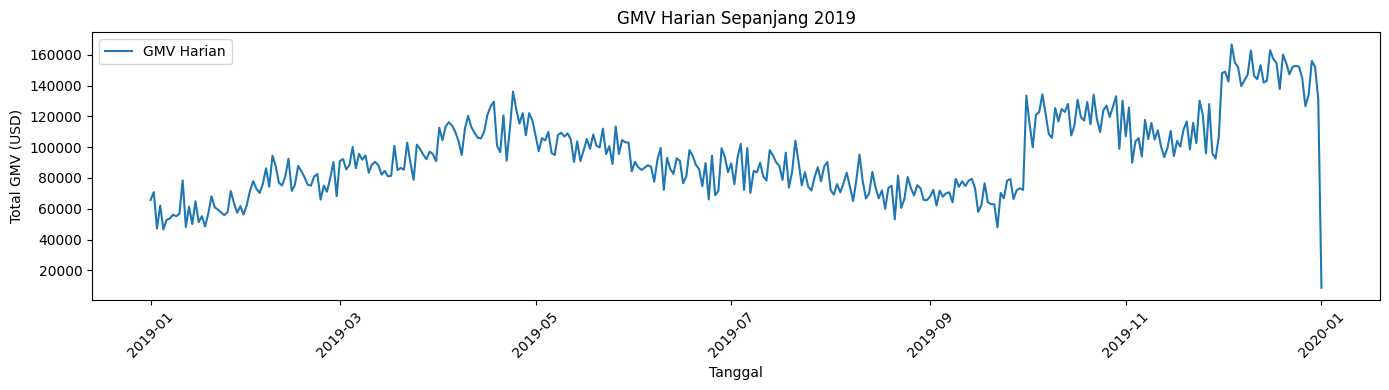

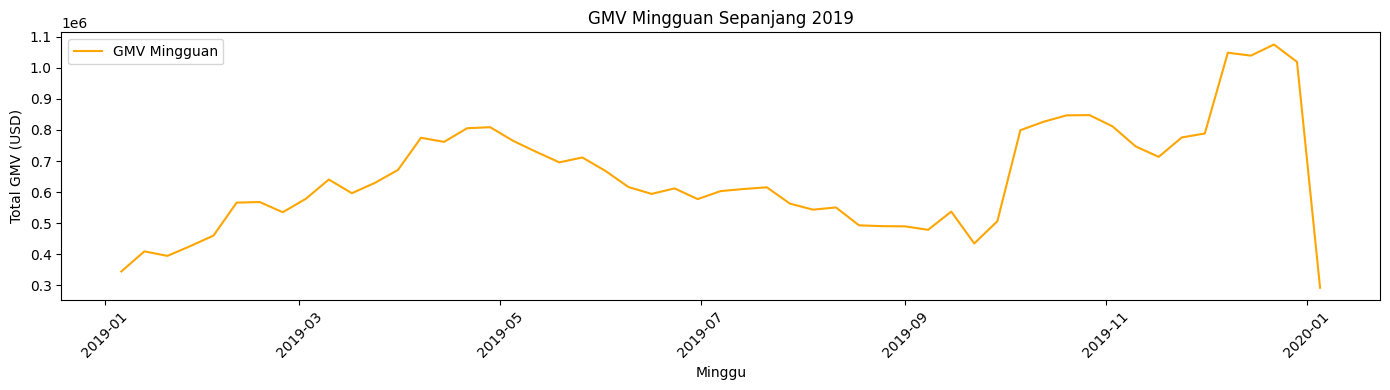

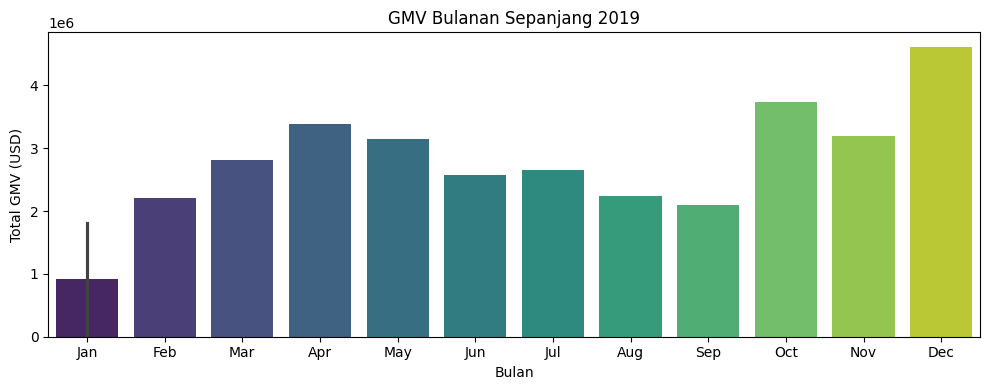

In [20]:
# --- Grafik GMV Harian ---
plt.figure(figsize=(14, 4))
sns.lineplot(data=daily_summary, x=daily_summary.index, y='Total GMV', label='GMV Harian')
plt.title('GMV Harian Sepanjang 2019')
plt.xlabel('Tanggal')
plt.ylabel('Total GMV (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Grafik GMV Mingguan ---
plt.figure(figsize=(14, 4))
sns.lineplot(data=weekly_summary, x=weekly_summary.index, y='Total GMV', label='GMV Mingguan', color='orange')
plt.title('GMV Mingguan Sepanjang 2019')
plt.xlabel('Minggu')
plt.ylabel('Total GMV (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Grafik GMV Bulanan ---
plt.figure(figsize=(10, 4))
sns.barplot(x=monthly_summary.index.strftime('%b'), y=monthly_summary['Total GMV'], palette='viridis')
plt.title('GMV Bulanan Sepanjang 2019')
plt.xlabel('Bulan')
plt.ylabel('Total GMV (USD)')
plt.tight_layout()
plt.show()

3. dentifikasi top 10 produk yang membawa revenue terbesar dalam 3 bulan terakhir dan produk apa saja yang bisa di-bundling berdasarkan hasil analisis.

In [21]:
# --- Produk Paling Sering Dibeli Sepanjang Tahun ---
top_products_all_year = df_all.groupby('Product')['Quantity Ordered'] \
    .sum().sort_values(ascending=False).head(10)
print("Top Produk Sepanjang Tahun:")
print(top_products_all_year)

# --- Filter 3 Bulan Terakhir (Oktober–Desember 2019) ---
last_3_months = df_all.loc['2019-10-01':'2019-12-31']

# --- Top 10 Produk Berdasarkan Revenue di 3 Bulan Terakhir ---
top10_revenue_3months = last_3_months.groupby('Product')['Sales'] \
    .sum().sort_values(ascending=False).head(10)
print("\nTop 10 Produk dengan Revenue Tertinggi (Okt–Des 2019):")
print(top10_revenue_3months)

# --- Analisis Bundling Produk: Kombinasi Produk dalam 1 Order ---
from itertools import combinations
from collections import Counter

# Ambil hanya order yang memiliki lebih dari satu produk
bundle_df = df_all[df_all.duplicated(subset='Order ID', keep=False)].copy()

# Gabungkan nama produk per order
bundle_df['Grouped'] = bundle_df.groupby('Order ID')['Product'] \
    .transform(lambda x: ','.join(x))
bundle_df = bundle_df[['Order ID', 'Grouped']].drop_duplicates()

# Hitung kombinasi produk (pasangan)
count = Counter()
for row in bundle_df['Grouped']:
    products = row.split(',')
    count.update(Counter(combinations(products, 2)))

# Tampilkan 10 kombinasi produk paling sering dibeli bersamaan
top_bundles = count.most_common(10)
print("\nTop 10 Produk yang Sering Dibeli Bersamaan:")
for combo, freq in top_bundles:
    print(f"{combo[0]} + {combo[1]} : {freq} kali")

Top Produk Sepanjang Tahun:
Product
AAA Batteries (4-pack)        31017.0
AA Batteries (4-pack)         27635.0
USB-C Charging Cable          23975.0
Lightning Charging Cable      23217.0
Wired Headphones              20557.0
Apple Airpods Headphones      15661.0
Bose SoundSport Headphones    13457.0
27in FHD Monitor               7550.0
iPhone                         6849.0
27in 4K Gaming Monitor         6244.0
Name: Quantity Ordered, dtype: float64

Top 10 Produk dengan Revenue Tertinggi (Okt–Des 2019):
Product
Macbook Pro Laptop            2733600.00
iPhone                        1600900.00
ThinkPad Laptop               1373986.26
Google Phone                  1083000.00
27in 4K Gaming Monitor         843158.38
Apple Airpods Headphones       789000.00
34in Ultrawide Monitor         786959.29
Flatscreen TV                  495000.00
Bose SoundSport Headphones     454054.59
27in FHD Monitor               370775.28
Name: Sales, dtype: float64

Top 10 Produk yang Sering Dibeli Bersamaan

4. top 5 kota yang memiliki order terbanyak dan 5 kota yang memiliki total dan rata-rata spending terbesar.

In [22]:
# --- Gabungkan City dan State menjadi satu kolom ---
df_all['City_Full'] = df_all['City'] + ', ' + df_all['State']

# --- Top 5 Kota dengan Jumlah Order Terbanyak ---
top5_city_orders = df_all.groupby('City_Full')['Order ID'] \
    .nunique().sort_values(ascending=False).head(5)
print("Top 5 Kota dengan Jumlah Order Terbanyak:")
print(top5_city_orders)

# --- Top 5 Kota dengan Total Spending Terbesar ---
top5_city_total_spending = df_all.groupby('City_Full')['Sales'] \
    .sum().sort_values(ascending=False).head(5)
print("\nTop 5 Kota dengan Total Spending Terbesar:")
print(top5_city_total_spending)

# --- Top 5 Kota dengan Rata-rata Spending per Order ---
avg_spending_per_order_by_city = df_all.groupby('City_Full').agg({
    'Sales': 'sum',
    'Order ID': 'nunique'
})
avg_spending_per_order_by_city['Avg Spending per Order'] = \
    avg_spending_per_order_by_city['Sales'] / avg_spending_per_order_by_city['Order ID']

top5_city_avg_spending = avg_spending_per_order_by_city \
    .sort_values(by='Avg Spending per Order', ascending=False).head(5)

print("\nTop 5 Kota dengan Rata-rata Spending per Order Tertinggi:")
print(top5_city_avg_spending[['Avg Spending per Order']])

Top 5 Kota dengan Jumlah Order Terbanyak:
City_Full
San Francisco, CA    42898
Los Angeles, CA      28498
New York City, NY    23848
Boston, MA           19092
Atlanta, GA          14253
Name: Order ID, dtype: int64

Top 5 Kota dengan Total Spending Terbesar:
City_Full
San Francisco, CA    8262203.91
Los Angeles, CA      5452570.80
New York City, NY    4664317.43
Boston, MA           3661642.01
Atlanta, GA          2795498.58
Name: Sales, dtype: float64

Top 5 Kota dengan Rata-rata Spending per Order Tertinggi:
                   Avg Spending per Order
City_Full                                
Atlanta, GA                    196.134048
New York City, NY              195.585266
Seattle, WA                    194.614029
Portland, OR                   194.523483
Dallas, TX                     194.380295


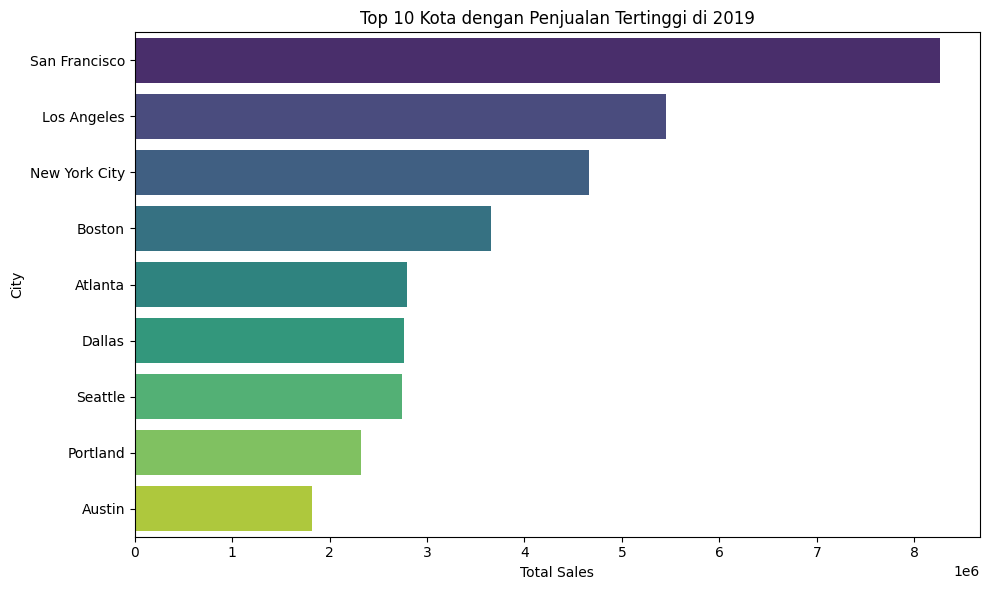

In [48]:
# Hitung total penjualan per kota
city_sales = df_all.groupby('City')['Sales'].sum().sort_values(ascending=False).head(10)

# Visualisasi
plt.figure(figsize=(10, 6))
sns.barplot(x=city_sales.values, y=city_sales.index, palette='viridis')
plt.title('Top 10 Kota dengan Penjualan Tertinggi di 2019')
plt.xlabel('Total Sales')
plt.ylabel('City')
plt.tight_layout()
plt.show()

Top Kota Penjualan:

* New York, Los Angeles, dan San Francisco mendominasi total GMV.

* Rekomendasi: Fokus promosi & distribusi di kota-kota besar ini.

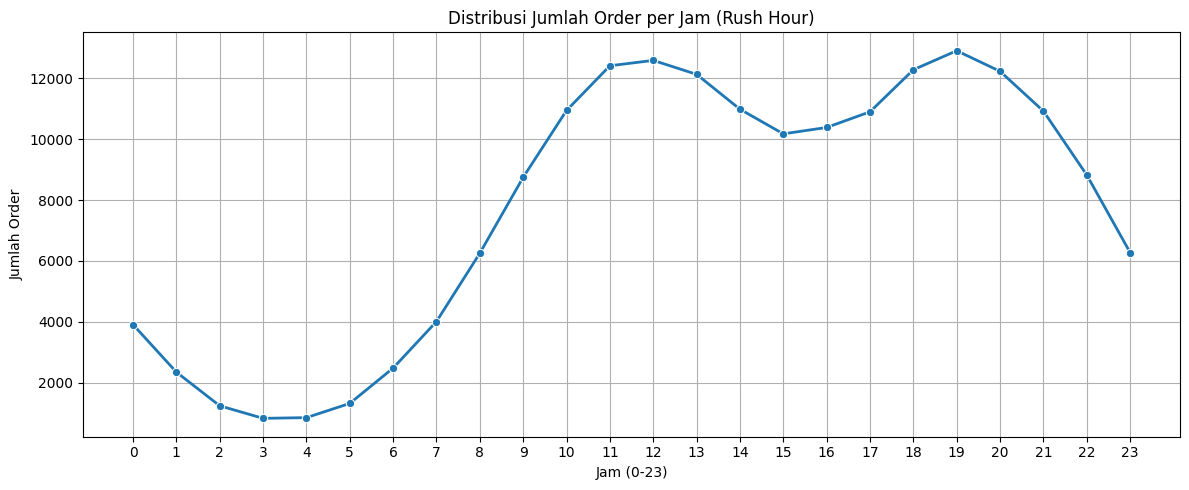

In [49]:
# Hitung jumlah order per jam
hourly_orders = df_all.groupby('Hour')['Order ID'].count()

# Visualisasi
plt.figure(figsize=(12, 5))
sns.lineplot(x=hourly_orders.index, y=hourly_orders.values, marker='o', linewidth=2)
plt.title('Distribusi Jumlah Order per Jam (Rush Hour)')
plt.xlabel('Jam (0-23)')
plt.ylabel('Jumlah Order')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()


Rush Hour:

* Puncak transaksi terjadi pada jam 10.00–14.00 dan naik lagi saat 19.00–21.00.

* Rekomendasi: Jadwalkan promo Flash Sale atau iklan digital di jam-jam tersebut.



# TIME SERIES DATA

**CASE STUDY**

Tim marketing ingin memahami pola penjualan dari waktu ke waktu untuk menyusun strategi promosi tahunan yang lebih efektif. Lakukan analisis time series untuk mengidentifikasi apakah terdapat pola atau tren penjualan yang berulang di bulan-bulan tertentu dalam tiap tahunnya.
Beberapa hal yang dapat dianalisis antara lain:

Bulan-bulan dengan penjualan tertinggi dan terendah setiap tahunnya.
Pola musiman (seasonality) jika ada.
Tren penjualan secara umum (meningkat, menurun, stagnan).

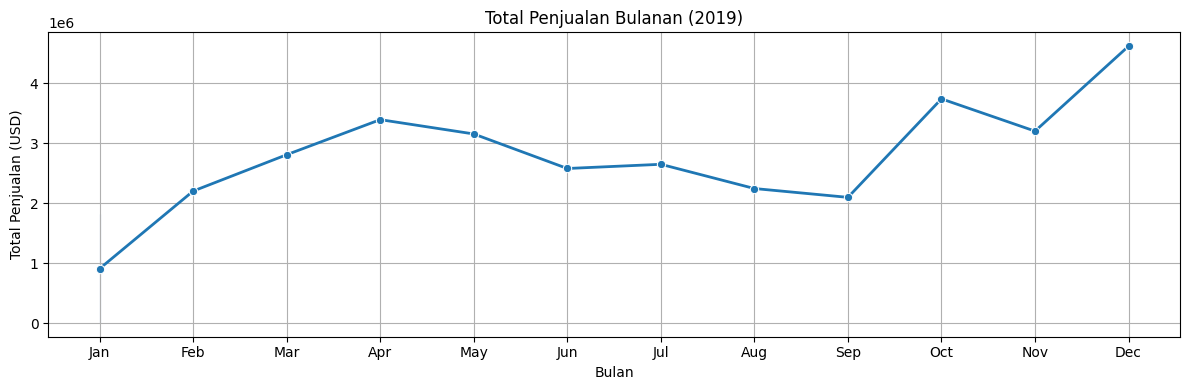

In [23]:
# --- Total Penjualan Bulanan ---
monthly_sales = df_all.resample('M')['Sales'].sum()
monthly_sales.index.name = 'Month'
month_labels = monthly_sales.index.strftime('%b')  # label nama bulan

plt.figure(figsize=(12, 4))
sns.lineplot(x=month_labels, y=monthly_sales.values, marker='o', linewidth=2)
plt.title('Total Penjualan Bulanan (2019)')
plt.xlabel('Bulan')
plt.ylabel('Total Penjualan (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

Bulan dengan Penjualan Tertinggi dan Terendah
Penjualan tertinggi terjadi di bulan November dan Desember.

Lonjakan ini sangat mungkin disebabkan oleh event besar seperti:

* Black Friday dan Cyber Monday (akhir November)

* Natal dan liburan akhir tahun (Desember)

* Penjualan terendah terjadi di bulan Februari.
Kemungkinan karena durasi bulan yang lebih pendek dan tidak banyak kampanye besar dilakukan.

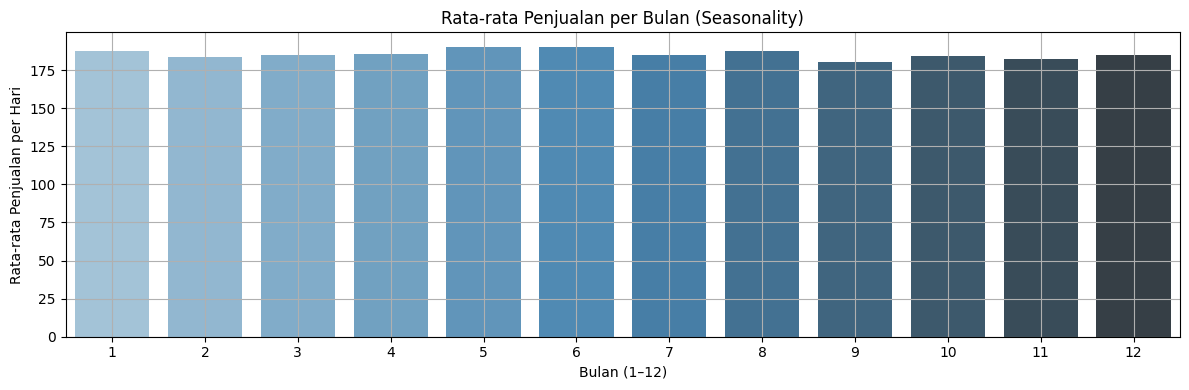

In [24]:
# --- Rata-rata Penjualan per Bulan (Seasonality) ---
monthly_avg_sales = df_all.groupby(df_all.index.month)['Sales'].mean()

plt.figure(figsize=(12, 4))
sns.barplot(x=monthly_avg_sales.index, y=monthly_avg_sales.values, palette='Blues_d')
plt.title('Rata-rata Penjualan per Bulan (Seasonality)')
plt.xlabel('Bulan (1–12)')
plt.ylabel('Rata-rata Penjualan per Hari')
plt.grid(True)
plt.tight_layout()
plt.show()

* Terdapat pola musiman yang konsisten, di mana penjualan cenderung meningkat secara bertahap sepanjang tahun dan memuncak di akhir tahun.

* Rata-rata penjualan per hari juga memperlihatkan peningkatan signifikan di Q4 dibanding Q1 dan Q2.

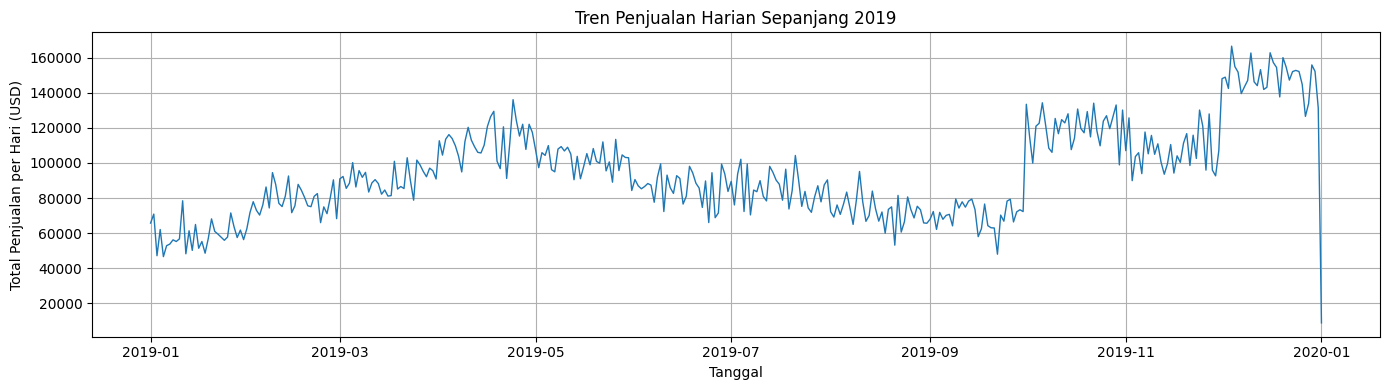

In [25]:
# --- Tren Penjualan Harian Sepanjang Tahun ---
daily_sales = df_all.resample('D')['Sales'].sum()

plt.figure(figsize=(14, 4))
sns.lineplot(x=daily_sales.index, y=daily_sales.values, linewidth=1)
plt.title('Tren Penjualan Harian Sepanjang 2019')
plt.xlabel('Tanggal')
plt.ylabel('Total Penjualan per Hari (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

* Secara garis besar, penjualan menunjukkan tren meningkat dari awal hingga akhir tahun.

* Fluktuasi harian tetap terlihat, namun pola tahunan menunjukkan bahwa bisnis mengalami pertumbuhan yang kuat dan berulang secara musiman.

OVERALL

* Jadikan Q4 sebagai momen promosi utama dengan anggaran iklan dan kampanye yang lebih agresif.

* Perlu ada strategi pengungkit di Q1–Q2, seperti diskon bundling, flash sale, atau kolaborasi produk untuk menjaga ritme penjualan.

* Gunakan pola seasonal sebagai dasar perencanaan tahunan (budgeting, campaign, stok, dan resource).


# FORECASTING ANALYSIS + MODEL

In [26]:
# ---  data time series harian ---
daily_ts = df_all.resample('D').agg({
    'Order ID': 'nunique'
}).rename(columns={'Order ID': 'Transactions'})
daily_ts['Visitors'] = daily_ts['Transactions']  # Asumsi 1 visitor = 1 transaksi unik

# --- Split train-test (30 hari terakhir sebagai test) ---
train = daily_ts[:-30]
test = daily_ts[-30:]

In [36]:
# Fungsi untuk evaluasi model
def evaluate_model(y_true, y_pred, model_name):
    y_pred = np.maximum(0, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    y_true_cleaned = y_true.copy()
    y_true_cleaned[y_true_cleaned == 0] = 1e-9  # hindari pembagian nol
    mape = np.mean(np.abs((y_true - y_pred) / y_true_cleaned)) * 100

    print(f"{model_name}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")
    return rmse, mae, mape

HOT - WINTER

In [42]:
# hot winter fungsi
def plot_predictions(y_train, y_val, y_test, y_pred_val, y_pred_test, model_name):
    plt.figure(figsize=(15, 6))
    plt.plot(y_train.index, y_train, label='Data Historis (Train)', color='blue', alpha=0.7)

    if y_val is not None:
        plt.plot(y_val.index, y_val, label='Data Validasi (Aktual)', color='black', linewidth=2)
        if y_pred_val is not None:
            y_pred_val_series = pd.Series(y_pred_val, index=y_val.index)
            plt.plot(y_val.index, y_pred_val_series, label=f'Prediksi {model_name} (Validasi)', linestyle='--', color='red')

    if y_test is not None:
        plt.plot(y_test.index, y_test, label='Data Testing (Aktual)', color='green', linewidth=2)
        if y_pred_test is not None:
            y_pred_test_series = pd.Series(y_pred_test, index=y_test.index)
            plt.plot(y_test.index, y_pred_test_series, label=f'Prediksi {model_name} (Testing)', linestyle='--', color='orange')

    plt.title(f'Prediksi {model_name} vs. Aktual', fontsize=16)
    plt.xlabel('Tanggal', fontsize=12)
    plt.ylabel('Jumlah Transaksi', fontsize=12)
    plt.axvline(x=y_train.index.max(), color='grey', linestyle=':', label='Akhir Data Historis')

    if y_val is not None and len(y_val) > 0:
        plt.axvline(x=y_val.index.max(), color='gray', linestyle='--', label='Akhir Data Validasi')



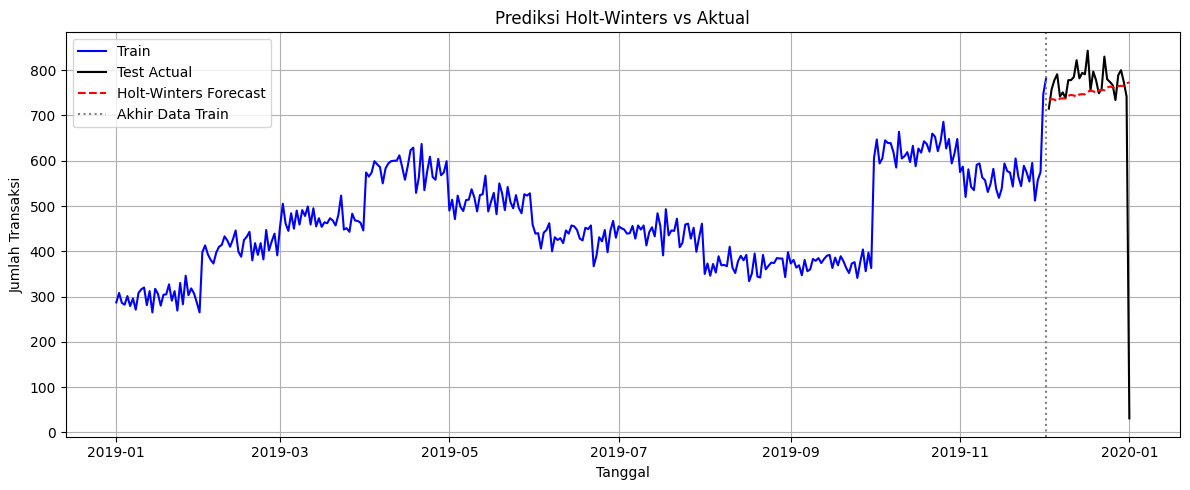

In [43]:
plt.figure(figsize=(12, 5))
plt.plot(train.index, train['Transactions'], label='Train', color='blue')
plt.plot(test.index, test['Transactions'], label='Test Actual', color='black')
plt.plot(y_pred_hw_val.index, y_pred_hw_val.values, label='Holt-Winters Forecast', linestyle='--', color='red')
plt.axvline(x=train.index.max(), color='grey', linestyle=':', label='Akhir Data Train')
plt.legend()
plt.title('Prediksi Holt-Winters vs Aktual')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Transaksi')
plt.grid(True)
plt.tight_layout()
plt.show()

LINEAR REGRESSION

Linear Regression
RMSE: 246.9675
MAE: 239.8273
MAPE: 84.58%


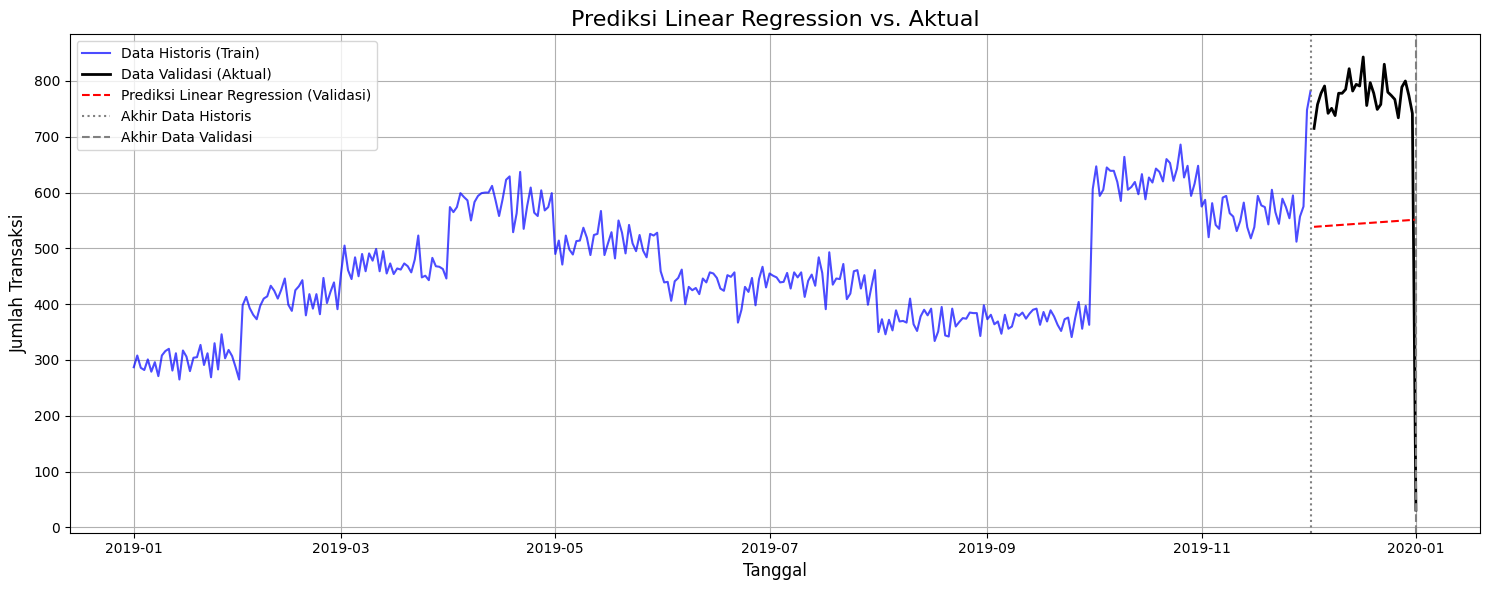

In [38]:
# === Pemodelan Linear Regression ===
X_train_lr = np.arange(len(train)).reshape(-1, 1)
X_test_lr = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)
y_train_lr = train['Transactions'].values

lr_model = LinearRegression().fit(X_train_lr, y_train_lr)
y_pred_lr_val = lr_model.predict(X_test_lr)

# Evaluasi Linear Regression
rmse_lr, mae_lr, mape_lr = evaluate_model(test['Transactions'], y_pred_lr_val, "Linear Regression")

# Visualisasi Linear Regression
plot_predictions(
    y_train=train['Transactions'],
    y_val=test['Transactions'],
    y_test=None,
    y_pred_val=y_pred_lr_val,
    y_pred_test=None,
    model_name="Linear Regression"
)

# NAIVE FORECAST

Naive Forecast
RMSE: 135.0051
MAE: 53.1000
MAPE: 80.25%


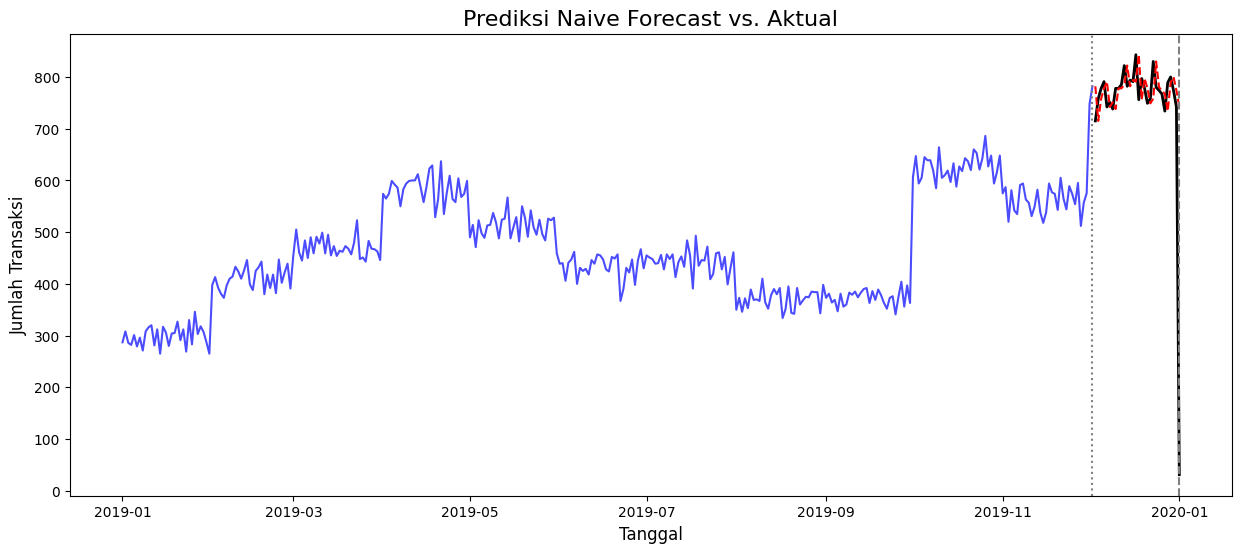

In [45]:
# === Naive Forecast ===
# Prediksi hari ini dimana 1 day lag
y_train_naive = train['Transactions']
y_val_naive = test['Transactions']

# prediksi naive: geser 1 hari ke depan
y_pred_naive_val = y_val_naive.shift(1)
y_pred_naive_val.iloc[0] = y_train_naive.iloc[-1]  # Isi awal dengan data terakhir dari train

# Evaluasi Naive Forecast
rmse_naive, mae_naive, mape_naive = evaluate_model(y_val_naive, y_pred_naive_val, "Naive Forecast")

# Visualisasi
plot_predictions(
    y_train=train['Transactions'],
    y_val=test['Transactions'],
    y_test=None,
    y_pred_val=y_pred_naive_val,
    y_pred_test=None,
    model_name="Naive Forecast"
)


# HOT WINTER FORECAST

Holt-Winters (Validation)
RMSE: 146.9987
MAE: 84.9851
MAPE: 83.43%


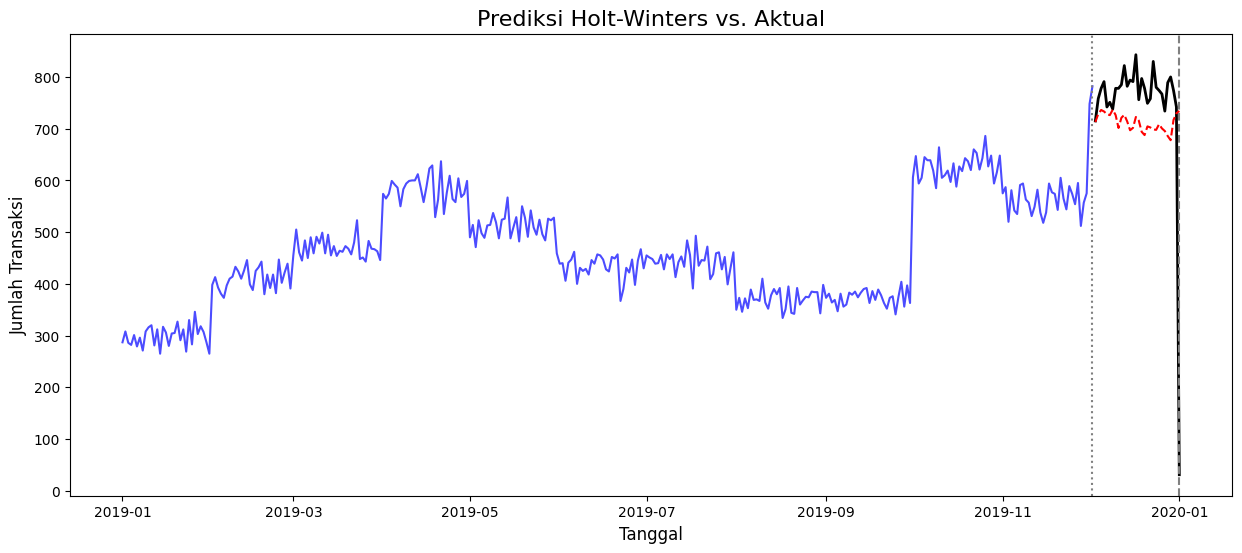

In [46]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# === Definisi Data Time Series ===
y_train_ts = train['Transactions']
y_val_ts = test['Transactions']

# === Pemodelan Holt-Winters ===
hw_model = ExponentialSmoothing(
    y_train_ts,
    seasonal='multiplicative',   # atau 'additive' jika musiman tidak proporsional
    seasonal_periods=30          # diasumsikan 1 bulan = 30 hari
).fit()

# === Forecast ke periode validasi ===
y_pred_hw_val = hw_model.forecast(len(y_val_ts))

# === Evaluasi Model ===
rmse_hw_val, mae_hw_val, mape_hw_val = evaluate_model(
    y_val_ts, y_pred_hw_val, "Holt-Winters (Validation)"
)

# === Visualisasi Prediksi vs Aktual ===
plot_predictions(
    y_train=y_train_ts,
    y_val=y_val_ts,
    y_test=None,
    y_pred_val=y_pred_hw_val,
    y_pred_test=None,
    model_name="Holt-Winters"
)


# SARIMA

SARIMA (0,0,1)(1,1,1,30)
RMSE: 283.9914
MAE: 276.6377
MAPE: 92.37%


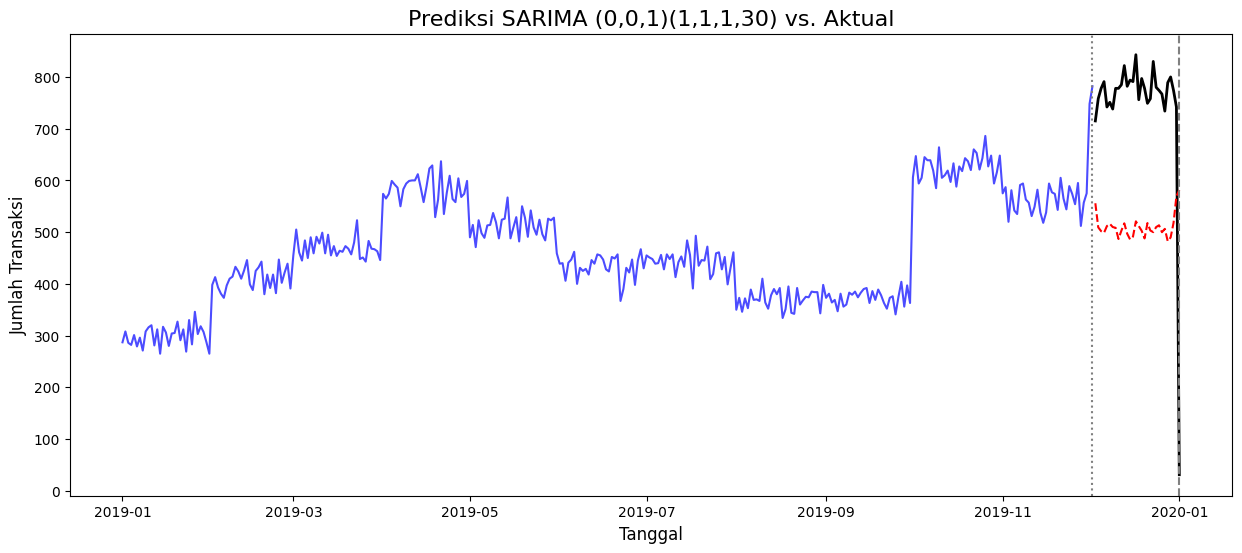

In [47]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Definisi ulang target
y_train_ts = train['Transactions']
y_val_ts = test['Transactions']

# === Pemodelan SARIMA ===
sarima_model = SARIMAX(
    y_train_ts,
    order=(0, 0, 1),
    seasonal_order=(1, 1, 1, 30),  # musiman 30 hari
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

# === Forecast ke periode validasi ===
y_pred_sarima_val = sarima_model.forecast(steps=len(y_val_ts))

# === Evaluasi Model ===
rmse_sarima_val, mae_sarima_val, mape_sarima_val = evaluate_model(
    y_val_ts, y_pred_sarima_val, "SARIMA (0,0,1)(1,1,1,30)"
)

# === Visualisasi ===
plot_predictions(
    y_train=y_train_ts,
    y_val=y_val_ts,
    y_test=None,
    y_pred_val=y_pred_sarima_val,
    y_pred_test=None,
    model_name="SARIMA (0,0,1)(1,1,1,30)"
)


Secara keseluruhan
 1. Naive Forecast
MAPE terendah (80.25%) menandakan model paling mendekati realita meski sangat sederhana.
Artinya: Polanya cenderung stabil dan tidak terlalu bergantung pada tren/seasonality.

2. Holt-Winters
Masih mempertimbangkan musiman, tapi performa turun.
Ini menunjukkan tidak ada pola musiman yang konsisten dalam transaksi harian kamu.

3. SARIMA
MAPE sangat tinggi (92.37%) dan MAE yang besar.
Model terlalu kompleks untuk dataset ini, kemungkinan tidak menangkap pola dengan baik atau seasonality 30 hari tidak cocok.

